In [110]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
%%capture 
!git install git-lfs
!git config --global credential.helper store

In [81]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):
    x = x * .5 + .5 # -1, 1 to 0, 1
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1,2,0).clip(0,1)*255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    output_im = Image.new("RGB", (size*len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## DreamBooth

In [54]:
from diffusers import StableDiffusionPipeline
model_id = "sd-dreambooth-library/mr-potato-head"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

safety_checker\model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

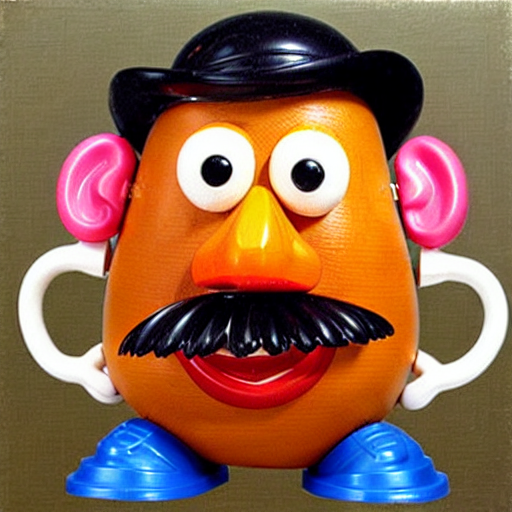

In [55]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

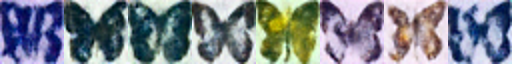

In [86]:
from diffusers import DDPMPipeline


butterfly_pipeline = DDPMPipeline.from_pretrained('johnowhitaker/ddpm-butterflies-32px').to(device)
images = butterfly_pipeline(batch_size=8).images

make_grid(images)

### download butterfly image data

In [56]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [57]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
image_size=32
batch_size=64

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([.5],[.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Repo card metadata block was not found. Setting CardData to empty.


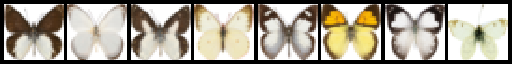

In [58]:
xb = next(iter(train_dataloader))['images'].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [59]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [60]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=.001, beta_end=.004)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

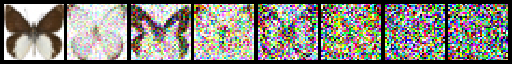

In [61]:
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb,noise,timesteps)
print(f"Noisy X shape {noisy_xb.shape}")
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [62]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model = model.to(device)

In [63]:
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

In [64]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
(noisy_xb.shape, model_prediction.shape)

(torch.Size([8, 3, 32, 32]), torch.Size([8, 3, 32, 32]))

# 4.2.4

In [65]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2",
)

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)

        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), 
            device=clean_images.device
        ).long() # why long?

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0] # why 0 again?

        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        losses.append(loss.item())

        optimizer.step() # which is first?
        optimizer.zero_grad() # which is first?

    if (epoch+1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
        

C:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\diffusers\configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [73]:
print('1111111111111111111')
for epoch in range(30):
    print(epoch, (epoch+1), (epoch+1) % 5)
    if (epoch+1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
print('1111111111111111111')

In [72]:
sum(losses[-len(train_dataloader):]) / len(train_dataloader)

0.0632279512938112

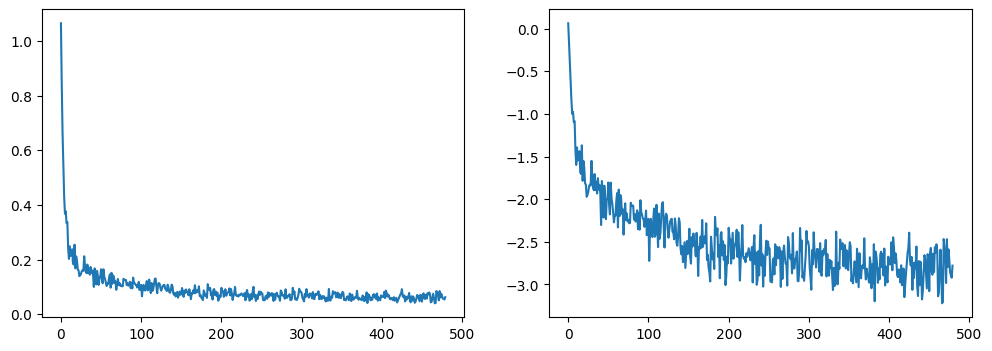

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [87]:
butterfly_pipeline.unet

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

  0%|          | 0/1000 [00:00<?, ?it/s]

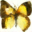

In [89]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

In [90]:
image_pipe.save_pretrained("my_pipeline")

In [98]:
??image_pipe.__call__

Signature:
image_pipe.__call__(
    batch_size: int = 1,
    generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None,
    num_inference_steps: int = 1000,
    output_type: Optional[str] = 'pil',
    return_dict: bool = True,
) -> Union[diffusers.pipelines.pipeline_utils.ImagePipelineOutput, Tuple]
Source:   
    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        r"""
        The call function to the pipeline for generation.

        Args:
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate.
            generator (`torch.Generator`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Ge

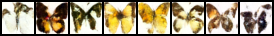

In [99]:
sample = torch.randn(8, 3, 32, 32).to(device)
for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample
show_images(sample)

In [104]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'mix060514/sd-class-butterflies-32'

In [111]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="",
    repo_id=hub_model_id
)
api.upload_folder(folder_path='my_pipeline/unet', path_in_repo='',
    repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj='my_pipeline/model_index.json',
    path_in_repo='model_index.json', 
    repo_id=hub_model_id
)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mix060514/sd-class-butterflies-32/commit/af7745353f32e3111dac676df972e00ebe348dc1', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='af7745353f32e3111dac676df972e00ebe348dc1', pr_url=None, pr_revision=None, pr_num=None)

In [114]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

'''python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
'''

"""
card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/mix060514/sd-class-butterflies-32/commit/9f2c25d46322b993758afb60efeb5e47f8b3efef', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='9f2c25d46322b993758afb60efeb5e47f8b3efef', pr_url=None, pr_revision=None, pr_num=None)

model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

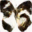

In [115]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained(f'{hub_model_id}')
image = pipeline().images[0]
image